In [3]:
# See http://www.wikimedecine.fr/Electrocardiogramme_(ECG)_-_%C3%A9l%C3%A9ments_d%27interpr%C3%A9tation

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import datetime, time
from funs import *

import wfdb

In [174]:
sig_wdb, fields_wdb = wfdb.rdsamp('mimic2wdb/matched/s00076/3924340_0004', pbdl=1, dldir='data/mimic2wdb/s00076')
sig, fields = wfdb.rdsamp('mimic2db/a40104/a40104_000000', pbdl=1, dldir='data')
print(fields_wdb)
print(fields)
fs_wdb = fields_wdb['fs']
fs = fields['fs']

File data/mimic2wdb/s00076/3924340_0004.hea is already present.
File data/mimic2wdb/s00076/3924340_0004.dat is already present.
Downloaded all missing files for record.
{'nseg': 1, 'nsig': 5, 'fs': 125.0, 'nsamp': 6765000, 'basetime': '18:51:20.648', 'basedate': '', 'filename': ['3924340_0004.dat', '3924340_0004.dat', '3924340_0004.dat', '3924340_0004.dat', '3924340_0004.dat'], 'fmt': ['16', '16', '16', '16', '16'], 'sampsperframe': [1, 1, 1, 1, 1], 'skew': [0, 0, 0, 0, 0], 'byteoffset': [0, 0, 0, 0, 0], 'gain': [1023.0, 1023.0, 512.0, 510.0, 512.0], 'units': ['pm', 'NU', 'mV', 'mV', 'mV'], 'baseline': [0, 0, 255, 256, 255], 'initvalue': [0, 478, 772, -32768, -32768], 'signame': ['RESP', 'PLETH', 'II', 'V', 'AVR'], 'nsampseg': [], 'comments': []}
{'nseg': 1, 'nsig': 2, 'fs': 125.0, 'nsamp': 14917500, 'basetime': '16:34:36.912', 'basedate': '30/07/2010', 'filename': ['a40104_000000.dat', 'a40104_000000.dat'], 'fmt': ['80', '80'], 'sampsperframe': [1, 1], 'skew': [0, 0], 'byteoffset': [0

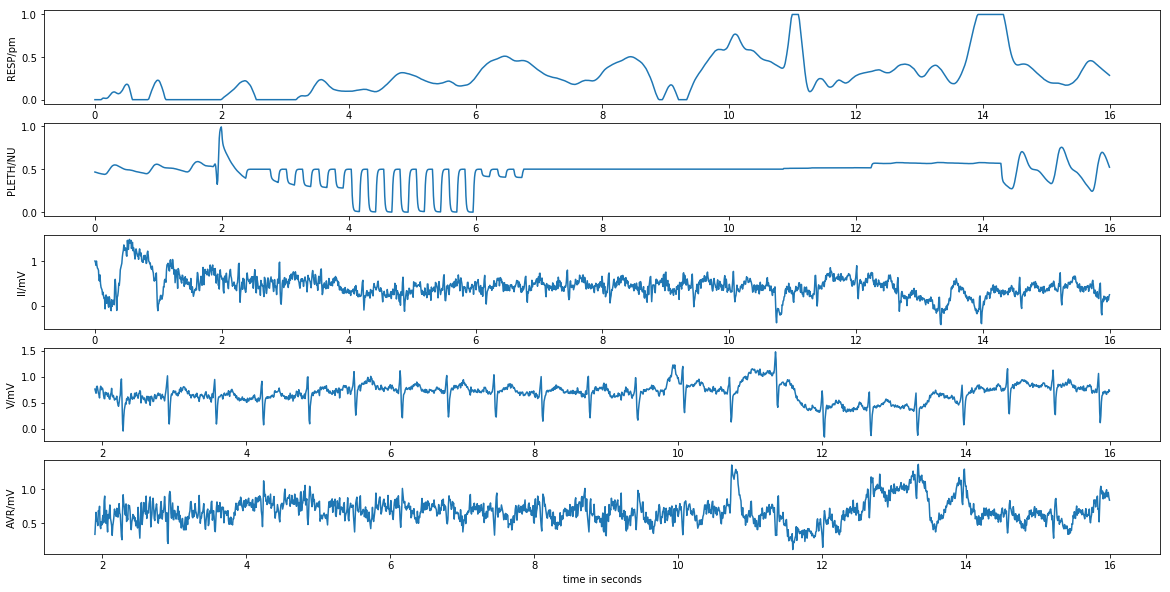

In [150]:
sig1 = sig[:2000]
myplot(sig1, fields)

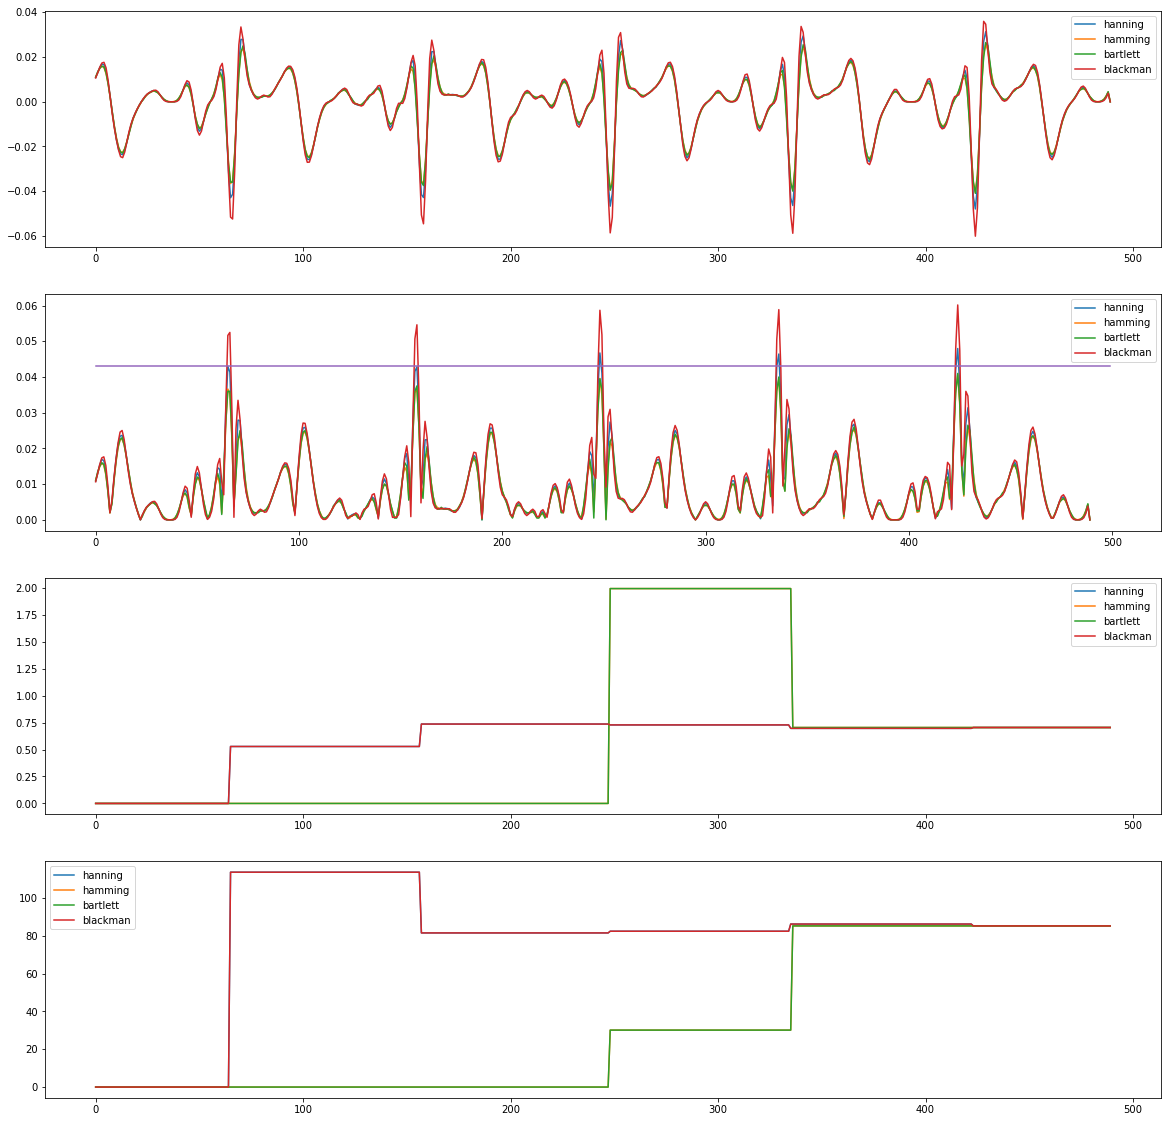

0.0421764152231


In [157]:
def get_rr(sig, window):
    smoothed = smooth(sig, window=window)[10:-10]
    signal_diff = np.diff(smoothed)
    signal_diff = np.append(signal_diff, 0)
    abs_diff = np.sqrt(signal_diff ** 2)
    ecg_threshold = np.average(abs_diff) * 4.5

    count = 0
    last_val = .0
    current_rr = .0
    current_rate = .0

    rr_intervals_array = []
    rr_intervals_rate = []

    for k, val in enumerate(abs_diff):
        count = count + 1
        if (val > ecg_threshold and last_val < ecg_threshold):
            current_rr = count / (fields['fs'])
            current_rate = 60.0 / current_rr
            count = 0
        last_val = val
        rr_intervals_array.append(current_rr)
        rr_intervals_rate.append(current_rate if current_rate < 220 else 0)

    return signal_diff, abs_diff, rr_intervals_array, rr_intervals_rate, ecg_threshold

def plot_rr2(sig, signal_diff, abs_diff, rr_intervals_array, rr_intervals_rate, ecg_threshold):
    fig, ax = plt.subplots(4, figsize=(20, 20))
    ax[0].plot(signal_diff)
    ax[1].plot(abs_diff)
    ax[1].plot([0, len(sig)-1], [ecg_threshold, ecg_threshold])
    ax[2].plot(rr_intervals_array, '.')
    ax[3].plot(rr_intervals_rate)
    plt.show()

def plot_rr(sig, window):
    plot_rr2(sig, *get_rr(sig, window))

# windows = ['hanning', 'hamming', 'bartlett', 'blackman']

# fig, ax = plt.subplots(4, figsize=(20, 20))
# for window in windows:
#     sd, ad, rra, rrr, ecg = get_rr(sig1[:, 0], window)
#     ax[0].plot(sd, label=window)
#     ax[1].plot(ad, label=window)
#     ax[2].plot(rra, label=window)
#     ax[3].plot(rrr, label=window)
    
# ax[1].plot([0, len(sig1[:, 0])-1], [ecg, ecg])
# ax[0].legend()
# ax[1].legend()
# ax[2].legend()
# ax[3].legend()
# fig.savefig('rr_different_windows.png', dpi=300)
# plt.show()

(14917500, 2)


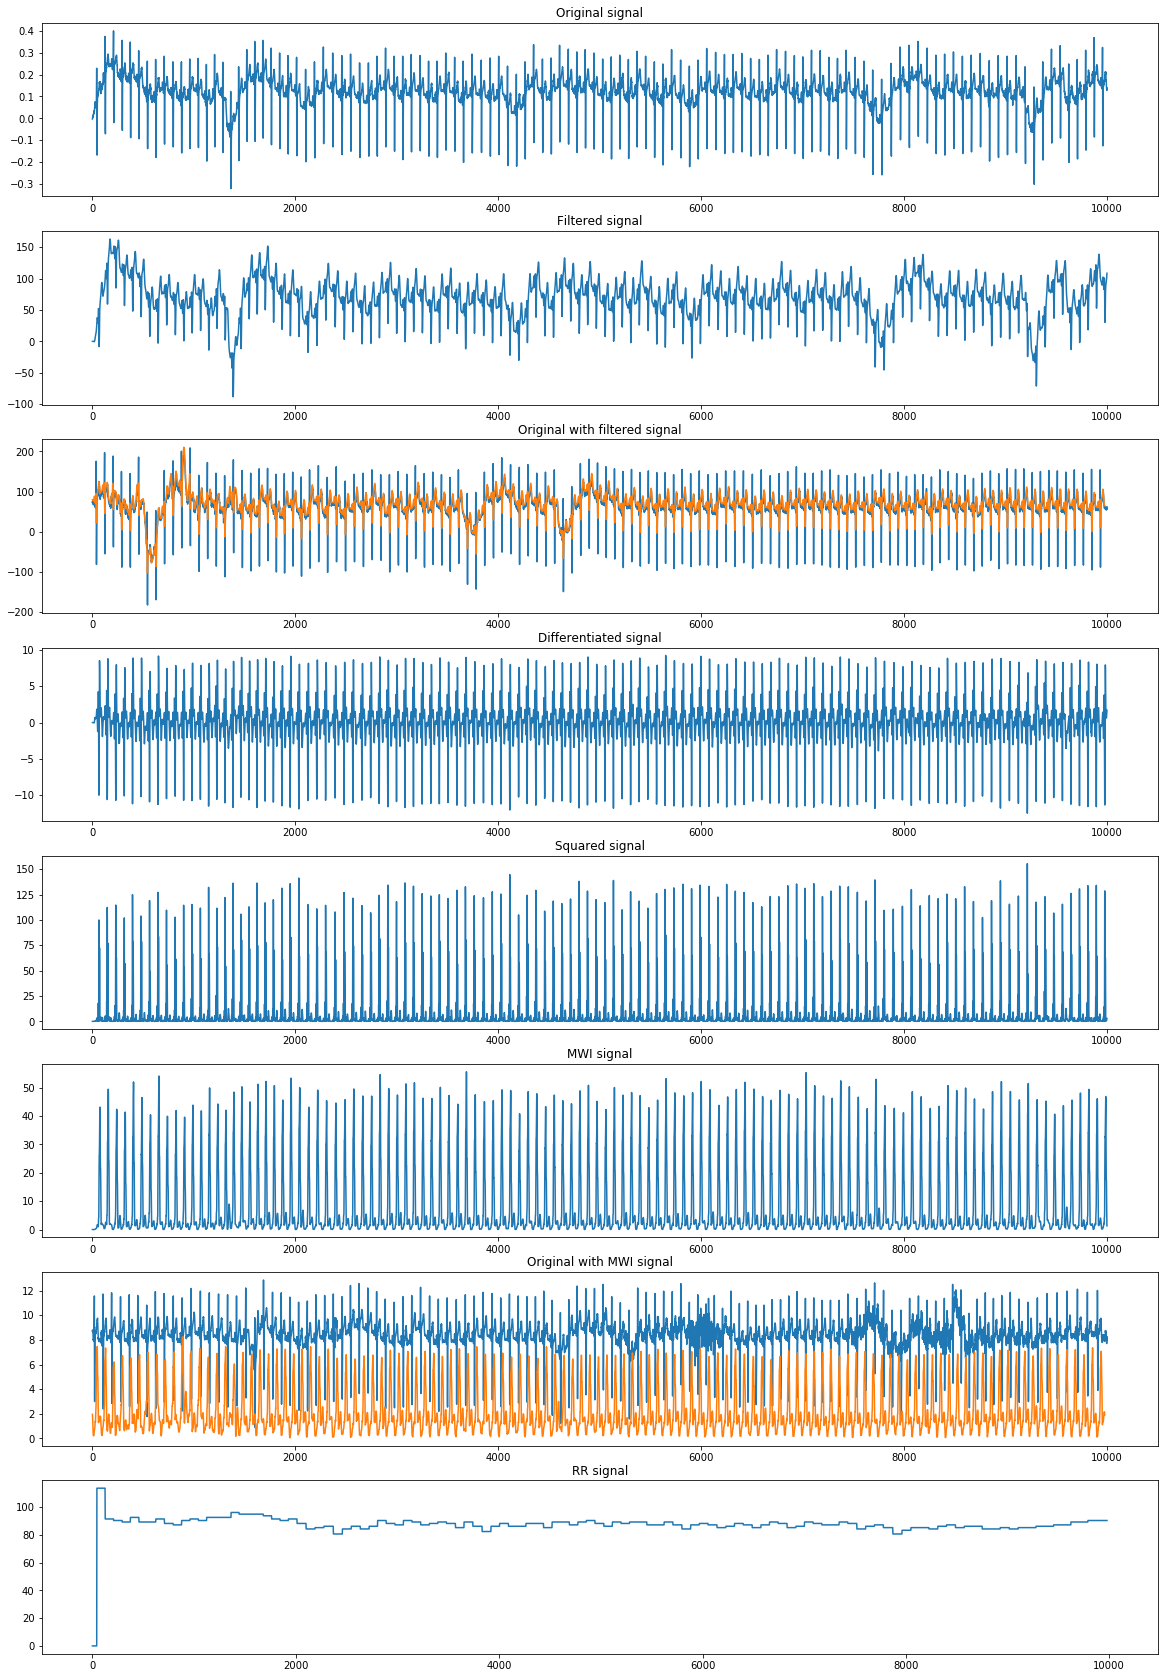

In [235]:
from dsfaker.generators import *
from queue import Queue


# Pan Tompkins real-time QRS detector
#   Steps: ECG -> Filters -> Derivation -> Squaring function -> Integration -> Adjusting thresholds -> Decision -> Result

class History(Generator):
    def __init__(self, generator, size, initial_values=None):
        if initial_values is None:
            self.history = numpy.zeros(size, dtype=numpy.float64)
        else:
            assert size == len(initial_values)
            self.history = numpy.asarray(initial_values)
        self.idx = 0
        
        self.generator = generator
        self.size = size
    
    def get_prev(self, i):
        return self.history[(self.size + self.idx + i) % self.size]
    
    def _put(self, e):
        if self.idx == self.size:
            self.idx = 0
        self.history[self.idx] = e
        self.idx += 1
    
    def get_single(self) -> float:
        e = self.generator.get_single()
        self._put(e)
        return e

    def get_batch(self, batch_size: int) -> numpy.array:
        vals = self.generator.get_batch(batch_size)
        for e in vals:
            self._put(e)
        return vals
    
    def get_mean(self):
        return numpy.sum(self.history) / self.size


class LowPass(Generator):
    def __init__(self, generator):
        self.x = History(generator, 12)
        self.old2 = 0
        self.old1 = 0
        self.delay = 6 + (generator.delay if hasattr(generator, 'delay') else 0)
    
    def get_single(self):
        xn6 = self.x.get_prev(-6)
        xn12 = self.x.get_prev(-12)
        xn = self.x.get_single()
        res = 2 * self.old1 - self.old2 + xn - 2 * xn6 + xn12
        self.old2 = self.old1
        self.old1 = res
        return res
    
    def get_batch(self, batch_size):
        res = []
        for _ in range(batch_size):
            res.append(self.get_single())
        return numpy.asarray(res)

class HighPass(Generator):
    def __init__(self, generator):
        self.x = History(generator, 32)
        self.old1 = 0
        self.delay = 16 + (generator.delay if hasattr(generator, 'delay') else 0)
    
    def get_single(self):
        xn16 = self.x.get_prev(-16)
        xn32 = self.x.get_prev(-32)
        xn = self.x.get_single()
        res = 32 * xn16 - (self.old1 + xn - xn32)
        self.old1 = res
        return res
    
    def get_batch(self, batch_size):
        res = []
        for _ in range(batch_size):
            res.append(self.get_single())
        return numpy.asarray(res)


class Differentiation(Generator):
    def __init__(self, generator):
        self.x = History(generator, 5)
        self.delay = 2 + (generator.delay if hasattr(generator, 'delay') else 0)
        self.get_single()
        self.get_single()
    
    def get_single(self):
        xnl2 = self.x.get_prev(-4)
        xnl1 = self.x.get_prev(-3)
        xnp1 = self.x.get_prev(-2)
        xnp2 = self.x.get_prev(-1)
        self.x.get_single()
        return 1.0/8.0 * (-xnl2 -2*xnl1 + 2*xnp1 + xnp2)
    
    def get_batch(self, batch_size):
        res = []
        for _ in range(batch_size):
            res.append(self.get_single())
        return numpy.asarray(res)

class MovingWindowIntegration(Generator):
    def __init__(self, generator, size):
        self.x = History(generator, size)
        self.delay =  generator.delay if hasattr(generator, 'delay') else 0
    
    def get_single(self):
        res = self.x.get_mean()
        self.x.get_single()
        return res
    
    def get_batch(self, batch_size):
        res = []
        for _ in range(batch_size):
            res.append(self.get_single())
        return numpy.asarray(res)

class RR(Generator):
    def __init__(self, generator, frequency):
        self.generator = generator
        self.fs = frequency
        self.count = 0
        self.last_val = .0
        self.current_rr = .0
        self.current_rate = .0
    
    def get_single(self):
        threshold = 10
        val = self.generator.get_single()
        self.count += 1
        if val > threshold and self.last_val < threshold:
            self.current_rr = self.count / self.fs
            self.current_rate = 60.0 / self.current_rr
            self.count = 0
        self.last_val = val
        return self.current_rate
    
    def get_batch(self, batch_size):
        res = []
        for _ in range(batch_size):
            res.append(self.get_single())
        return numpy.asarray(res)
    
class QRS(Generator):
    def low_pass(self):
        2*low_pass()
    
    def __init__(self, generator):
        self.generator = History(generator, 12)
    
    def get_single(self) -> float:
        return

    def get_batch(self, batch_size: int) -> numpy.array:
        return

print(sig.shape)

size = 10000

# sig1 = sig[:size, 0]
sig1 = sig_wdb[10000:, 3]
fss = fs_wdb

data_gen = (RepeatPattern(sig1)-0.5)/2.0
lp_gen = LowPass(data_gen.copy())
hp_gen = HighPass(lp_gen)
hp_delay = hp_gen.delay
diff_gen = Differentiation(hp_gen.copy())
sq_gen = diff_gen.copy() ** 2

moving_avrg = 100 #ms
mwi_gen = MovingWindowIntegration(sq_gen.copy(), int((moving_avrg/1000)*fss))

rr_gen = RR(mwi_gen.copy(), fss)

# qrs = QRS(data_gen)

fig, ax = plt.subplots(8, figsize=(20, 30))
ax[0].plot(data_gen.get_batch(size))
ax[0].set_title('Original signal')
ax[1].plot(hp_gen.get_batch(size))
ax[1].set_title('Filtered signal')
ax[2].plot((data_gen*530).get_batch(size), label='Original')
ax[2].plot(hp_gen.get_batch(size)[delay:], label='Filtered')
ax[2].set_title('Original with filtered signal')
ax[3].plot(diff_gen.get_batch(size))
ax[3].set_title('Differentiated signal')
ax[4].plot(sq_gen.get_batch(size))
ax[4].set_title('Squared signal')
ax[5].plot(mwi_gen.get_batch(size))
ax[5].set_title('MWI signal')
ax[6].plot(((data_gen+0.3)*20).get_batch(size))
ax[6].plot(numpy.sqrt(mwi_gen.get_batch(size)[delay:]))
ax[6].set_title('Original with MWI signal')
ax[7].plot(rr_gen.get_batch(size)[delay:])
ax[7].set_title('RR signal')
plt.show()